# Assignment 3: Exploring Tree-Based Regression Methods for 3D Sinusoidal Data
## DTSC 680: Applied Machine Learning

## Name: 

## Directions and Overview

The main purpose of this assignment is for you to gain experience using tree-based methods to solve simple regression problems.  In this assignment, you will fit a `Gradient-Boosted Regression Tree`, a `Random Forest`, and a `Decision Tree` to a noisy 3D sinusoidal data set.  Since these models can be trained very quickly on the supplied data, I want you to first manually adjust hyperparameter values and observe their influence on the model's predictions.  That is, you should manually sweep the hyperparameter space and try to hone in on the optimal hyperparameter values, again, _manually_.  (Yep, that means guess-and-check: pick some values, train the model, observe the prediction curve, repeat.)

But wait, there's more! Merely attempting to identify the optimal hyperparameter values is not enough.  Be sure to really get a visceral understanding of how altering a hyperparameter in turn alters the model predictions (i.e. the prediction curve).  This is how you will build your machine learning intuition!

So, play around and build some models.  When you are done playing with hyperparameter values, you should try to set these values to the optimal values manually (you're likely going to be _way_ off).  Then, retrain the model.  Next in this assignment, we will perform several grid searches, so you'll be able to compare your "optimal" hyperparameter values with those computed from the grid search.

We will visualize model predictions for the optimal `Gradient-Boosted Regression Tree`, a `Random Forest`, and `Decision Tree` models that were determined by the grid searches.  Next, you will compute the generalization error on the test set for the three models.

## Preliminaries

Let's import some common packages:

In [70]:
# Common imports
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
%matplotlib inline
# %matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot3Ddata(x, y, z):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})

    for ax in axs.flat:
        ax.scatter(x, y, z, c='blue')  

        ax.set_xlabel('x', color='red')
        ax.set_ylabel('y', color='red')
        ax.set_zlabel('z', color='red')

        # Set axis limits
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(min(y), max(y))
        ax.set_zlim(min(z), max(z))

    # Set viewing angles
    axs[0,0].view_init(0, 90)
    axs[0,1].view_init(45, 0)
    axs[1,0].view_init(30, 45)
    axs[1,1].view_init(30, 20)

    plt.tight_layout()
    plt.show()

def plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})
    
    for ax in axs.flat:
        # Plot model prediction
        ax.plot(fit_x, fit_y, fit_z, c='red', linestyle='solid')
        ax.scatter(fit_x, fit_y, fit_z, c='r')
        
        # Plot training data
        ax.scatter(scat_x, scat_y, scat_z, c='b')
    
    # Labels and limits
    ax.set_xlabel('x', color='red')
    ax.set_ylabel('y', color='red')
    ax.set_zlabel('z', color='red')
    
    ax.set_xlim(min(scat_x), max(scat_x))
    ax.set_ylim(min(scat_y), max(scat_y))
    ax.set_zlim(min(scat_z), max(scat_z))

    # Set views
    axs[0,0].view_init(0, 90)
    axs[0,1].view_init(45, 0)
    axs[1,0].view_init(30, 45)
    axs[1,1].view_init(30, 20)

    plt.tight_layout()
    plt.show()

# Import and Split Data

Complete the following:



1. Begin by importing the data from the file called `3DSinusoidal.csv`.  Name the returned DataFrame `data`. 

2. Call [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with a `test_size` of 20%.  `x` and `y` will be your feature data and `z` will be your response data. Save the output into `X_train`, `X_test`, `z_train`, and `z_test`, respectively.  Specify the `random_state` parameter to be `42` (do this throughout the entire note book).

In [47]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("3DSinusoidal.csv")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    print(data)

X = data[['x', 'y']]  
y = data['z']

X_train, X_test, z_train, z_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This was my solution to the insane trend line. It took me about 7 or 8 tries before I finally got it to work. At least, I
# think this works. My trend line from view_init(0,90) is intelligible and clearly sinusoidal, even if the rest of the plots
# do not communicate this relationship. This is the best I could get it. I also tried a surface plot, and that plot was far
# more clear than this, but I need to move on. I have already spent too much time on this assignment.
X_train, z_train = zip(*sorted(zip(X_train.values, z_train), key=lambda x: x[0][0]))
X_train = pd.DataFrame(X_train, columns=['x', 'y'])
z_train = np.array(z_train)

             x         y         z
0     6.550561  0.918746  5.056359
1    11.314821  0.675399  2.048655
2     0.001797  0.250325  4.429342
3     4.749025 -0.644546  0.565993
4     2.305234  0.024039  6.768186
5     1.450450  0.184968  6.474788
6     2.925766  0.273935  4.277521
7     5.428051 -0.238184  1.565907
8     6.232404  0.399620  5.118993
9     8.463706 -0.123268  6.577486
10    6.584686  0.146335  6.043186
11   10.763394  0.643003  1.829758
12    3.211526 -0.095271  4.998139
13   13.793425 -0.136331  6.969996
14    0.430203  0.195038  6.554895
15   10.531670  0.695629  0.452567
16    6.555003  0.027588  4.492966
17    8.775872  0.189297  5.867996
18    2.205191 -0.260142  5.681313
19    3.111768 -0.311643  4.133787
20   12.578056 -0.311065  3.360567
21   15.209404  0.249025  5.965419
22    4.923251  0.171025  1.798509
23   10.874969  0.029604  0.160053
24   13.766277 -0.181267  6.797456
25   14.052437  0.241661  5.657969
26    1.335870  0.954082  7.535204
27    0.613471 -0.04

# Plot Data

Simply plot your training data here, so that you know what you are working with.  You must define a function called `plot3Ddata`, which accepts a Pandas DataFrame (composed of 3 spatial coordinates) and uses `scatter3D()` to plot the data.  Use this function to plot only the training data (recall that you don't even want to look at the test set, until you are ready to calculate the generalization error).  You must place the definition of this function in the existing code cell of the above __Preliminaries__ section, and have nothing other than the function invocation in the below cell. 

You must emulate the graphs shown in the respective sections below. Each of the graphs will have four subplots. Note the various viewing angles that each subplot presents - you can achieve this with the view_init() method. Be sure to label your axes as shown.

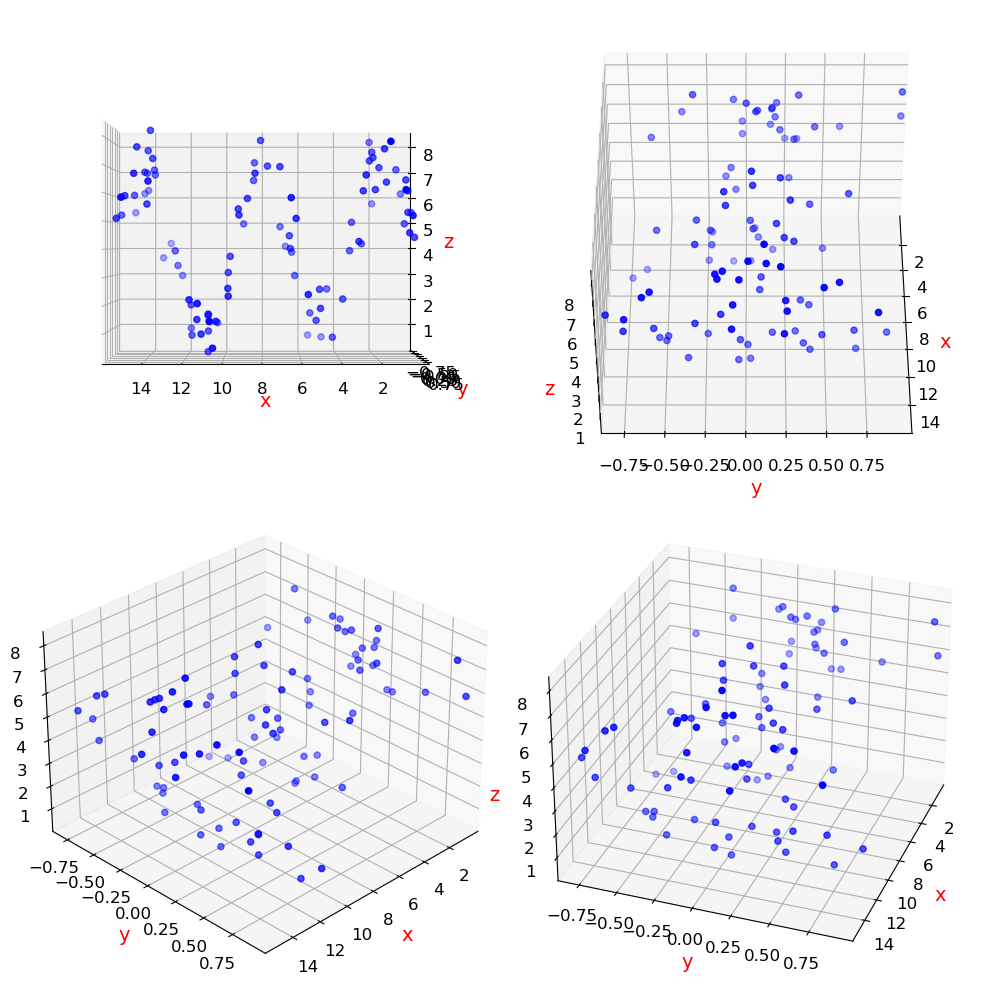

In [50]:
plot3Ddata(X_train['x'], X_train['y'], z_train)

## A Quick Note

In the following sections you will be asked to plot the training data along with the model's predictions for that data superimposed on it.  You must write a function called `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` that will plot this figure.  The function accepts six parameters as input, shown in the function signature.  All six input parameters must be NumPy arrays. The Numpy arrays called fit_x and fit_y represent the x and y coordinates from the training data and fit_z represents the model predictions from those coordinates (i.e. the prediction curve). The three Numpy arrays called `scat_x, scat_y,` and  `scat_z` represent the x, y, and z coordinates of the training data.   

You must place the definition of the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function in the existing code cell of the above __Preliminaries__ section. (The function header is already there - you must complete the function definition.)

You will use the `plotscatter3Ddata()` function in each of the below __Plot Model Predictions for Training Set__ portion of the three __Explore 3D Data__ sections, as well as the __Visualize Optimal Model Predictions__ section.

___Important: Below, you will be asked to plot the model's prediction curve along with the training data.  Even if you correctly train the model, you may find that your trendline is very ugly when you first plot it.  If this happens to you, try plotting the model's predictions using a scatter plot rather than a connected line plot.  You should be able to infer the problem and solution with the trendline from examining this new scatter plot of the model's predictions. Your final solution, however, should be a connected line plot.___

Note: You must use the supplied data and not np.linspace() to create the prediction curve.

# Explore 3D Data: GradientBoostingRegressor

Fit a `GradientBoostingRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `learning_rate = <values>`
 - `max_depth = <values>`
 - `n_estimators = <values>`
 - `random_state = 42`

Initial "best values":
 - `learning_rate = <value>`
 - `max_depth = <value>`
 - `n_estimators = <value>`
 - `random_state = 42`

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Play around values
learning_rates = [.04]
max_depths = [1]
n_estimators = [1751]

# List for results
results = []

# Function to iterate through 'play around' values
for learning_rate in learning_rates:
    for max_depth in max_depths:
        for n_estimator in n_estimators:
            play_gbr_model = GradientBoostingRegressor(learning_rate=learning_rate,
                                                       max_depth=max_depth,
                                                       n_estimators=n_estimator,
                                                       random_state=42)

            play_gbr_model.fit(X_train, z_train)

            # Use trained model on test set to get predictions
            play_gbr_mod_preds = play_gbr_model.predict(X_test)

            # Calculate the mean squared error so I can find the best model by sorting.
            mse = mean_squared_error(z_test, play_gbr_mod_preds)

            # Store the results in the results list
            results.append({'learning_rate': learning_rate,
                            'max_depth': max_depth,
                            'n_estimator': n_estimator,
                            'mse': mse,})

            # Print the current parameters and MSE so I can examine how different values change model
            # print(f"Play Parameters: Learning rate={learning_rate}, Max depth={max_depth}, \
            # Estimators={n_estimator}")
            # print(f"Play MSE: {mse}")
            # print()

# Sort the results by MSE (should sort best model to first element by default since MSE will be lowest for best model)
sorted_results = sorted(results, key=lambda x: x['mse'])

# The best "play" parameters are the first element of sorted_results
best_play_parameters = sorted_results[0]

# Print the best parameter and MSE
print(f"Best 'play' parameters: Learning rate={best_play_parameters['learning_rate']}, \
Max depth={best_play_parameters['max_depth']}, Estimators={best_play_parameters['n_estimator']}")
print(f"Best MSE: {best_play_parameters['mse']}")


# Values "played around with":

# learning_rate = <.9, .7, .5, .3, .25, .2, .15, .12, .11, .1, .09, .08, .07, .06, .04, .03, .02, .01>
# max_depth = <50, 40, 30, 20, 15, 10, 8, 6, 5, 4, 3, 2, 1>
# n_estimators = <6000, 5500, 5000, 4500, 4250, 4000, 3750, 3500, 3250, 3000, 2750, 2500, 2250, 2000, 1750, 1500, 1250, 1000
# 1688, 1720, 1735, 1742, 1746, 1749, 1750, 1751, 1752, 1753, 1754, 1758, 1765, 1780, 1813>
# random_state = 42


# Initial "best values":

# learning_rate = <.04>
# max_depth = <1>
# n_estimators = <1751>
# random_state = 42

Best 'play' parameters: Learning rate=0.04, Max depth=1, Estimators=1751
Best MSE: 0.3619109108267839


In [71]:
# Train model with best parameters
gb_model = GradientBoostingRegressor(learning_rate=.04,
                                     max_depth=1,
                                     n_estimators=1751,
                                     random_state=42)

# Fit model
gb_model.fit(X_train, z_train)

# Use trained model to get predictions
gb_mod_preds = gb_model.predict(X_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

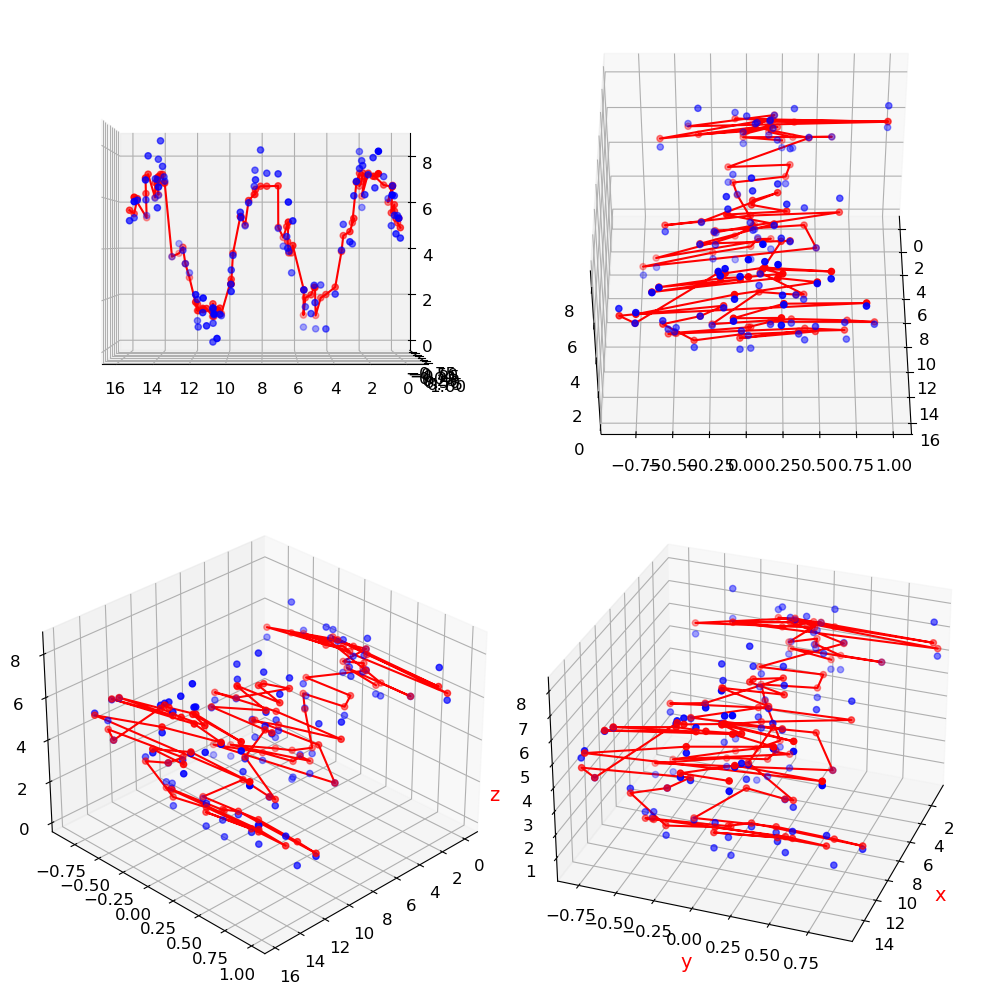

In [72]:
# Plot
plotscatter3Ddata(X_train['x'], X_train['y'], gb_mod_preds, X_train['x'], X_train['y'], z_train)

# The sinusoidal shape is obvious on the first subplot, but impossible to see on the other three. As for the crazy line (when,
# the line is plotted instead of a scatter plot), I am guessing to get a proper looking line I have to sort the values or 
# something. Not sure yet.

# Explore 3D Data: RandomForestRegressor

Fit a `RandomForestRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `min_samples_split = <values>`
 - `max_depth = <values>`
 - `n_estimators = <values>`
 - `random_state = 42`

Initial "best values":
 - `min_samples_split = <value>`
 - `max_depth = <value>`
 - `n_estimators = <value>`
 - `random_state = 42`

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Play around values
min_samples_splits = [8]
max_depths = [7]
n_estimators = [85]

# List for results
results = []

# Function to iterate through 'play around' values
for min_samples_split in min_samples_splits:
    for max_depth in max_depths:
        for n_estimator in n_estimators:
            play_rfr_model = RandomForestRegressor(min_samples_split=min_samples_split,
                                                  max_depth=max_depth,
                                                  n_estimators=n_estimator,
                                                  random_state=42)
            
            play_rfr_model.fit(X_train, z_train)

            # Use trained model on test set to get predictions
            play_rfr_mod_preds = play_rfr_model.predict(X_test)

            # Calculate the mean squared error so I can find the best model by sorting.
            mse = mean_squared_error(z_test, play_rfr_mod_preds)
            
            # Store the results in the results list so I can print them
            results.append({'min_samples_split': min_samples_split,
                      'max_depth': max_depth,
                      'n_estimator': n_estimator,
                      'mse': mse})
            
            # Print the current parameters and MSE so I can examine how different values change model
            # print(f"Play Parameters: Min Samples Split={min_samples_split}, Max depth={max_depth}, \
            # Estimators={n_estimator}")
            # print(f"Play MSE: {mse}")
            # print()
            
# Sort the results by MSE (should sort best model to first element by default because lowest MSE is best model)
sorted_results = sorted(results, key=lambda x: x['mse'])
            
            
            
# The best "play" parameters are the first element of sorted_results
best_play_parameters = sorted_results[0]
print(f"Best 'play' parameters: Min_Samples_Split={best_play_parameters['min_samples_split']}, \
Max depth={best_play_parameters['max_depth']}, Estimators={best_play_parameters['n_estimator']}")
print(f"Best MSE: {best_play_parameters['mse']}")


# Values "played around with":

# min_samples_split = <32, 20, 12, 10, 9, 8, 7, 6, 5, 4, 2>
# max_depth = <20, 15, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3 , 2, 1>
# n_estimators = <1000, 750, 500, 250, 150, 125, 100, 95, 90, 89, 88, 87, 86, 85, 84, 84, 83, 82, 81, 80, 75, 70, 65, 60, 55, 50>
# random_state = 42


# Initial "best values":

# min_samples_split = <8>
# max_depth = <7>
# n_estimators = <85>
# random_state = 42

Best 'play' parameters: Min_Samples_Split=8, Max depth=7, Estimators=85
Best MSE: 0.4723680381324214


In [73]:
# Train model with best parameters
rf_model = RandomForestRegressor(min_samples_split=8,
                                 max_depth=7,
                                 n_estimators=85,
                                 random_state=42)
# Fit model
rf_model.fit(X_train, z_train)

# Use trained model to get predictions
rf_mod_preds = rf_model.predict(X_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

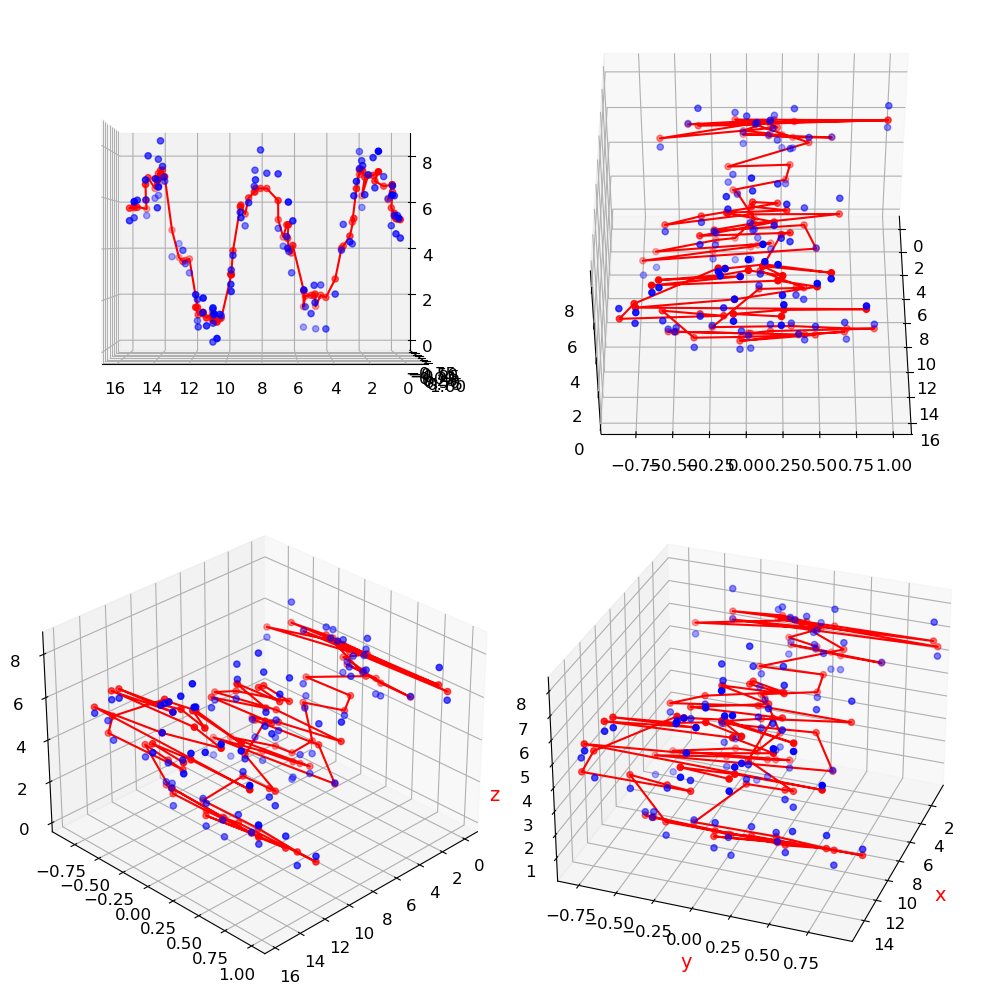

In [74]:
# Plot
plotscatter3Ddata(X_train['x'], X_train['y'], rf_mod_preds, X_train['x'], X_train['y'], z_train)

# Explore 3D Data: DecisionTreeRegressor

Fit a `DecisionTreeRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `splitter = <values>`
 - `max_depth = <values>`
 - `min_samples_split = <values>`
 - `random_state = 42`

Initial "best values":
 - `splitter = <value>`
 - `max_depth = <value>`
 - `min_samples_split = <value>`
 - `random_state = 42`

In [10]:
from sklearn.tree import DecisionTreeRegressor

# Play around values
splitter = ["best"]
min_samples_splits = [15]
max_depths = [6]

# List for results
results = []

# Function to iterate through 'play around' values
for min_samples_split in min_samples_splits:
    for max_depth in max_depths:
        for split in splitter:
            play_dtr_model = DecisionTreeRegressor(splitter=split,
                                                  min_samples_split=min_samples_split,
                                                  max_depth=max_depth,
                                                  random_state=42)
            
            play_dtr_model.fit(X_train, z_train)

            # Use trained model on test set to get predictions
            play_dtr_mod_preds = play_dtr_model.predict(X_test)

            # Calculate the mean squared error and accuracy of my predictions so I can find the best model by sorting.
            mse = mean_squared_error(z_test, play_dtr_mod_preds)
            
            # Store the results in the results list so I can print them
            results.append({'splitter': split,
                            'min_samples_split': min_samples_split,
                            'max_depth': max_depth,
                            'mse': mse})
            
            # Print the current parametersand MSE so I can examine how different values change model
            # print(f"Current Parameters: Splitter={split}, Min Samples Split={min_samples_split}, Max depth={max_depth}")
            # print(f"Current MSE: {mse}")
            # print()

# Sort the results by MSE (should sort best model to first element by default because lowest MSE is best model)
sorted_results = sorted(results, key=lambda x: x['mse'])

# The best "play" parameters are the first element of sorted_results
best_play_parameters = sorted_results[0]
print(f"Best 'play' parameters: Splitter={best_play_parameters['splitter']}, Min Samples Split={best_play_parameters['min_samples_split']}, \
Max depth={best_play_parameters['max_depth']}")
print(f"Best MSE: {best_play_parameters['mse']}")


# Values "played around with":

# splitter = <"best", "random">
# max_depth = <1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 20> There was no improvement in MSE after 6.
# min_samples_split = <20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1>
# random_state = 42

# Initial "best values":

# splitter = <"best">
# max_depth = <6>
# min_samples_split = <15>
# random_state = 42

Best 'play' parameters: Splitter=best, Min Samples Split=15, Max depth=6
Best MSE: 0.5965398038293587


In [75]:
# Train model with best parameters
dt_model = DecisionTreeRegressor(splitter='best',
                                 min_samples_split=15,
                                 max_depth=6,
                                 random_state=42)

# Fit model
dt_model.fit(X_train, z_train)

# Use trained model to get predictions
dt_mod_preds = dt_model.predict(X_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

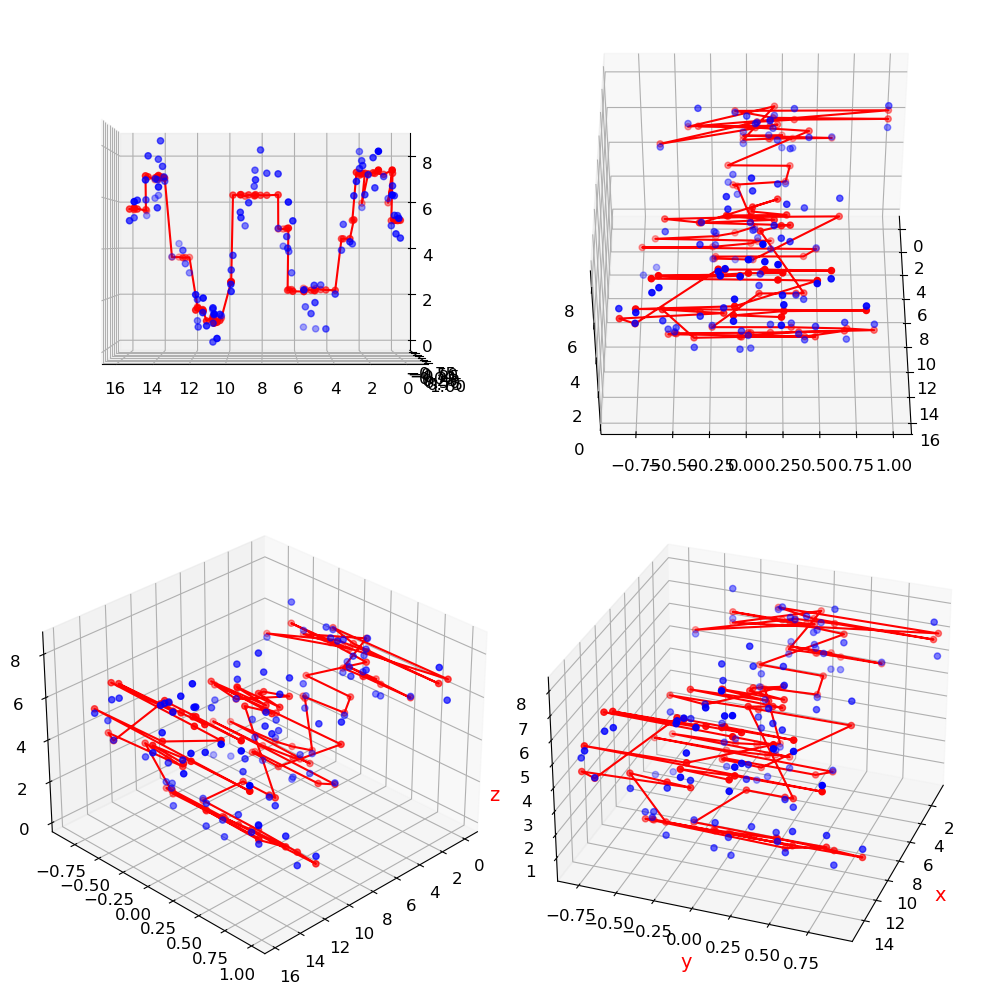

In [79]:
plotscatter3Ddata(X_train['x'], X_train['y'], dt_mod_preds, X_train['x'], X_train['y'], z_train)

# Perform Grid Searches

You will perform a series of grid searches, which will yield the optimal hyperparamter values for each of the three model types.  You can compare the values computed by the grid search with the values you manually found earlier.  How do these compare?

You must perform a course-grained grid search, with a very broad range of values first.  Then, you perform a second grid search using a tighter range of values centered on those identified in the first grid search.  You may have to use another round of grid searching too (it took me at least three rounds of grid searches per model to ascertain the optimal hyperparameter values below).

Note the following:

1. Be sure to clearly report the optimal hyperparameters in the designated location after you calculate them!

2. You must use `random_state=42` everywhere that it is needed in this notebook.

3. You must use grid search to compute the following hyperparameters:

   GradientBoostingRegressor:
    
     - `max_depth = <value>`
     - `n_estimators = <value>`
     - `learning_rate = <value>`

   RandomForestRegressor:
    
     - `max_depth = <value>`
     - `n_estimators = <value>`
     - `min_samples_split = <value>`

   DecisionTreeRegressor:
    
     - `splitter = <value>`
     - `max_depth = <value>`
     - `min_samples_split = <value>`
     
     
4. `learning rate` should be rounded to two decimals.
5. The number of cross-folds. Specify `cv=3`


## Perform Individual Model Grid Searches

In this section you will perform a series of grid searches to compute the optimal hyperparameter values for each of the three model types.

In [26]:
# Coarse-Grained GradientBoostingRegressor GridSearch

# I used the following website: https://www.kaggle.com/code/paulh2718/gradientboostingregressor-gridsearchcv/notebook, our
# textbook, page 79-81, and the video walkthrough for this code. I kept param_grid with the same name because I found lots
# of examples of grid searches and a lot use the same variable name, so it seemed like it is normal to name the dictionary
# param_grid when performing a grid search. This is simply copied from my assignment 2 and changed to fit this assignment.

from sklearn.model_selection import GridSearchCV

param_grid= {'learning_rate': [.1, .3, .5, .7, .9],
             'max_depth': [5, 10, 15, 20, 25, 30],
             'n_estimators': [500, 1000, 1500, 2000, 2500, 3000]}

gb_model_obj = GradientBoostingRegressor(random_state=42)

gb_gridsearch = GridSearchCV(gb_model_obj, param_grid, verbose=1, cv=3,)

gb_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',gb_gridsearch.best_params_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
The best parameters so far are:  {'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 1500}


In [27]:
# Second GradientBoostingRegressor GridSearch
param_grid= {'learning_rate': [.5, .6, .7, .8, .9],
             'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
             'n_estimators': [1000, 1250, 1500, 1750, 2000]}

gb_model_obj = GradientBoostingRegressor(random_state=42)

gb_gridsearch = GridSearchCV(gb_model_obj, param_grid, verbose=1, cv=3,)

gb_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',gb_gridsearch.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
The best parameters so far are:  {'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 2000}


In [28]:
# Third GradientBoostingRegressor GridSearch
param_grid= {'learning_rate': [.6, .65, .7, .75, .8],
             'max_depth': [2],
             'n_estimators': [1750, 1875, 2000, 2125, 2250]}

gb_model_obj = GradientBoostingRegressor(random_state=42)

gb_gridsearch = GridSearchCV(gb_model_obj, param_grid, verbose=1, cv=3,)

gb_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',gb_gridsearch.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters so far are:  {'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 1875}


In [29]:
# Fourth GradientBoostingRegressor GridSearch
param_grid= {'learning_rate': [.66, .67, .68, .69, .70, .71, .72, .73, .74],
             'max_depth': [2],
             'n_estimators': [1750, 1775, 1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000]}

gb_model_obj = GradientBoostingRegressor(random_state=42)

gb_gridsearch = GridSearchCV(gb_model_obj, param_grid, verbose=1, cv=3,)

gb_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',gb_gridsearch.best_params_)

Fitting 3 folds for each of 99 candidates, totalling 297 fits
The best parameters so far are:  {'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 1850}


In [30]:
# Fifth GradientBoostingRegressor GridSearch
param_grid= {'learning_rate': [.7],
             'max_depth': [2],
             'n_estimators': [1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875]}

gb_model_obj = GradientBoostingRegressor(random_state=42)

gb_gridsearch = GridSearchCV(gb_model_obj, param_grid, verbose=1, cv=3,)

gb_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',gb_gridsearch.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
The best parameters so far are:  {'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 1845}


In [31]:
# Sixth GradientBoostingRegressor GridSearch
param_grid= {'learning_rate': [.7],
             'max_depth': [2],
             'n_estimators': [1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849]}

gb_model_obj = GradientBoostingRegressor(random_state=42)

gb_gridsearch = GridSearchCV(gb_model_obj, param_grid, verbose=1, cv=3,)

gb_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',gb_gridsearch.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
The best parameters so far are:  {'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 1842}


On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class are:

- `learning_rate = <.7>`
- `max_depth = <2>`
- `n_estimators = <1842>`

In [32]:
# Coarse-Grained RandomForestRegressor GridSearch
param_grid= {'min_samples_split': [5, 10, 15, 20],
             'max_depth': [4, 8, 12, 16, 20, 24, 28, 32],
             'n_estimators': [200, 400, 600, 800, 1000]}

rf_model_obj = RandomForestRegressor(random_state=42)

rf_gridsearch = GridSearchCV(rf_model_obj, param_grid, verbose=1, cv=3,)

rf_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',rf_gridsearch.best_params_)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
The best parameters so far are:  {'max_depth': 4, 'min_samples_split': 20, 'n_estimators': 800}


In [33]:
# Second RandomForestRegressor GridSearch
param_grid= {'min_samples_split': [16, 18, 20, 22, 24],
             'max_depth': [2, 3, 4, 5, 6, 7],
             'n_estimators': [600, 700, 800, 900, 1000]}

rf_model_obj = RandomForestRegressor(random_state=42)

rf_gridsearch = GridSearchCV(rf_model_obj, param_grid, verbose=1, cv=3,)

rf_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',rf_gridsearch.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
The best parameters so far are:  {'max_depth': 2, 'min_samples_split': 24, 'n_estimators': 900}


In [34]:
# Third RandomForestRegressor GridSearch
param_grid= {'min_samples_split': [22, 24, 26, 28, 30],
             'max_depth': [2, 3, 4, 5, 6],
             'n_estimators': [800, 850, 900, 950, 1000]}

rf_model_obj = RandomForestRegressor(random_state=42)

rf_gridsearch = GridSearchCV(rf_model_obj, param_grid, verbose=1, cv=3,)

rf_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',rf_gridsearch.best_params_)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
The best parameters so far are:  {'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 850}


In [35]:
# Fourth RandomForestRegressor GridSearch
param_grid= {'min_samples_split': [28, 30, 32, 34, 36],
             'max_depth': [2],
             'n_estimators': [800, 825, 850, 875, 900]}

rf_model_obj = RandomForestRegressor(random_state=42)

rf_gridsearch = GridSearchCV(rf_model_obj, param_grid, verbose=1, cv=3,)

rf_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',rf_gridsearch.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters so far are:  {'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 825}


In [36]:
# Fifth RandomForestRegressor GridSearch
param_grid= {'min_samples_split': [29, 30, 31],
             'max_depth': [2],
             'n_estimators': [800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850]}

rf_model_obj = RandomForestRegressor(random_state=42)

rf_gridsearch = GridSearchCV(rf_model_obj, param_grid, verbose=1, cv=3,)

rf_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',rf_gridsearch.best_params_)

Fitting 3 folds for each of 33 candidates, totalling 99 fits
The best parameters so far are:  {'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 825}


In [37]:
# Sixth RandomForestRegressor GridSearch
param_grid= {'min_samples_split': [30],
             'max_depth': [2],
             'n_estimators': [821, 822, 823, 824, 825, 826, 827, 828, 829]}

rf_model_obj = RandomForestRegressor(random_state=42)

rf_gridsearch = GridSearchCV(rf_model_obj, param_grid, verbose=1, cv=3,)

rf_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',rf_gridsearch.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
The best parameters so far are:  {'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 823}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `max_depth = <2>`
- `n_estimators = <823>`
- `min_samples_split = <30>`

In [38]:
# Coarse-Grained DecisionTreeRegressor GridSearch
param_grid= {'splitter': ["best", "random"],
             'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
             'max_depth': [5, 10, 15, 20, 25]}

dt_model_obj = DecisionTreeRegressor(random_state=42)

dt_gridsearch = GridSearchCV(dt_model_obj, param_grid, verbose=1, cv=3,)

dt_gridsearch.fit(X_train, z_train)

print('The best parameters so far are: ',dt_gridsearch.best_params_)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
The best parameters so far are:  {'max_depth': 5, 'min_samples_split': 35, 'splitter': 'random'}


In [39]:
# Second DecisionTreeRegressor GridSearch
param_grid= {'splitter': ["random"],
             'min_samples_split': [30, 35, 40, 45, 50],
             'max_depth': [2, 3, 4, 5]}

dt_model_obj = DecisionTreeRegressor(random_state=42)

dt_gridsearch = GridSearchCV(dt_model_obj, param_grid, verbose=1, cv=3,)

dt_gridsearch.fit(X_train, z_train)

print('The best parameters are: ',dt_gridsearch.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 35, 'splitter': 'random'}


In [40]:
# Third DecisionTreeRegressor GridSearch
param_grid= {'splitter': ["random"],
             'min_samples_split': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
             'max_depth': [3]}

dt_model_obj = DecisionTreeRegressor(random_state=42)

dt_gridsearch = GridSearchCV(dt_model_obj, param_grid, verbose=1, cv=3,)

dt_gridsearch.fit(X_train, z_train)

print('The best parameters are: ',dt_gridsearch.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 32, 'splitter': 'random'}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `splitter = <'random'>`
- `max_depth = <3>`
- `min_samples_split = <32>`

# Visualize Optimal Model Predictions

In the previous section you performed a series of grid searches designed to identify the optimal hyperparameter values for all three models.  Now, use the `best_params_` attribute of the grid search objects from above to create the three optimal models below.  For each model, visualize the models predictions on the training set - this is what we mean by the "prediction curve" of the model.

### Create Optimal GradientBoostingRegressor Model

In [83]:
# learning_rate = <.7>
# max_depth = <2>
# n_estimators = <1842>

# Train model with best parameters
gb_model = GradientBoostingRegressor(learning_rate=.7,
                                     max_depth=2,
                                     n_estimators=1842,
                                     random_state=42)

# Fit model
gb_model.fit(X_train, z_train)

# Use trained model to get predictions
gb_mod_preds = gb_model.predict(X_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

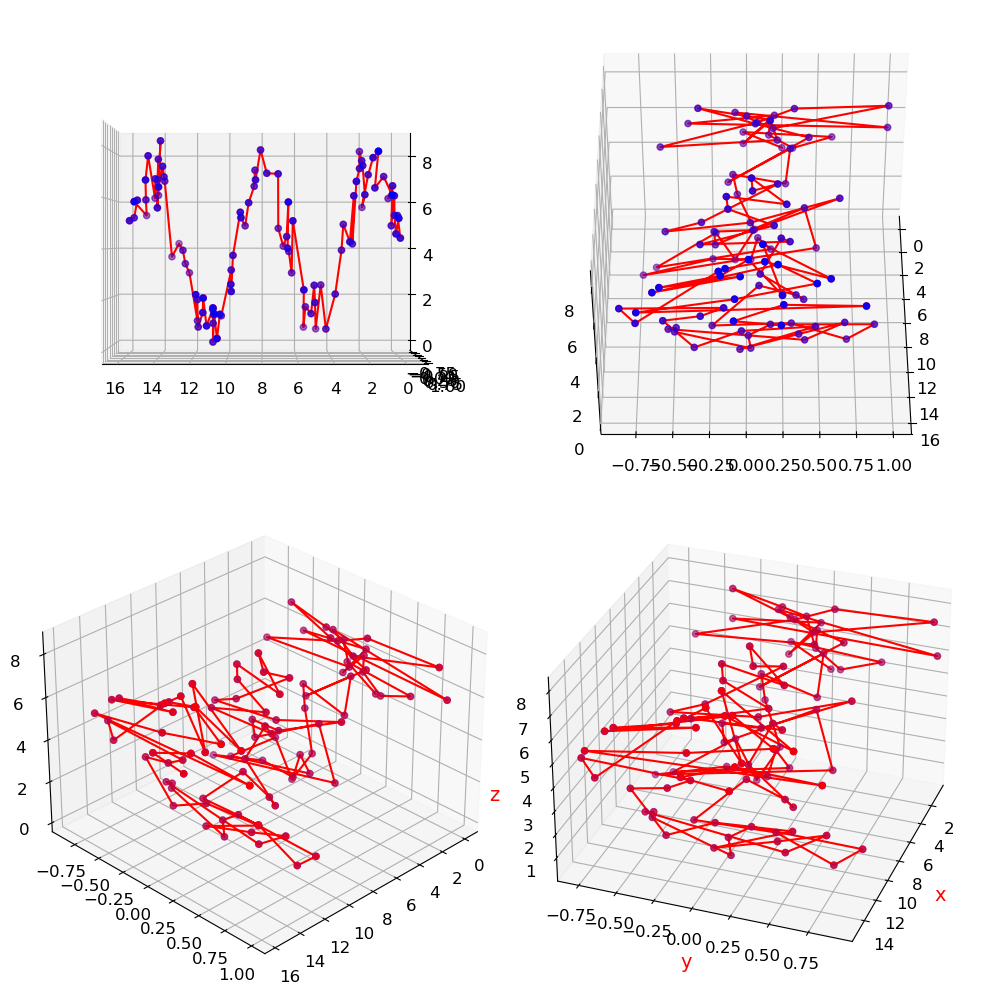

In [84]:
# Plot
plotscatter3Ddata(X_train['x'], X_train['y'], gb_mod_preds, X_train['x'], X_train['y'], z_train)

### Create Optimal RandomForestRegressor Model

In [85]:
# max_depth = <2>
# n_estimators = <823>
# min_samples_split = <30>

# Train model with best parameters
rf_model = RandomForestRegressor(min_samples_split=30,
                                 max_depth=2,
                                 n_estimators=823,
                                 random_state=42)
# Fit model
rf_model.fit(X_train, z_train)

# Use trained model to get predictions
rf_mod_preds = rf_model.predict(X_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

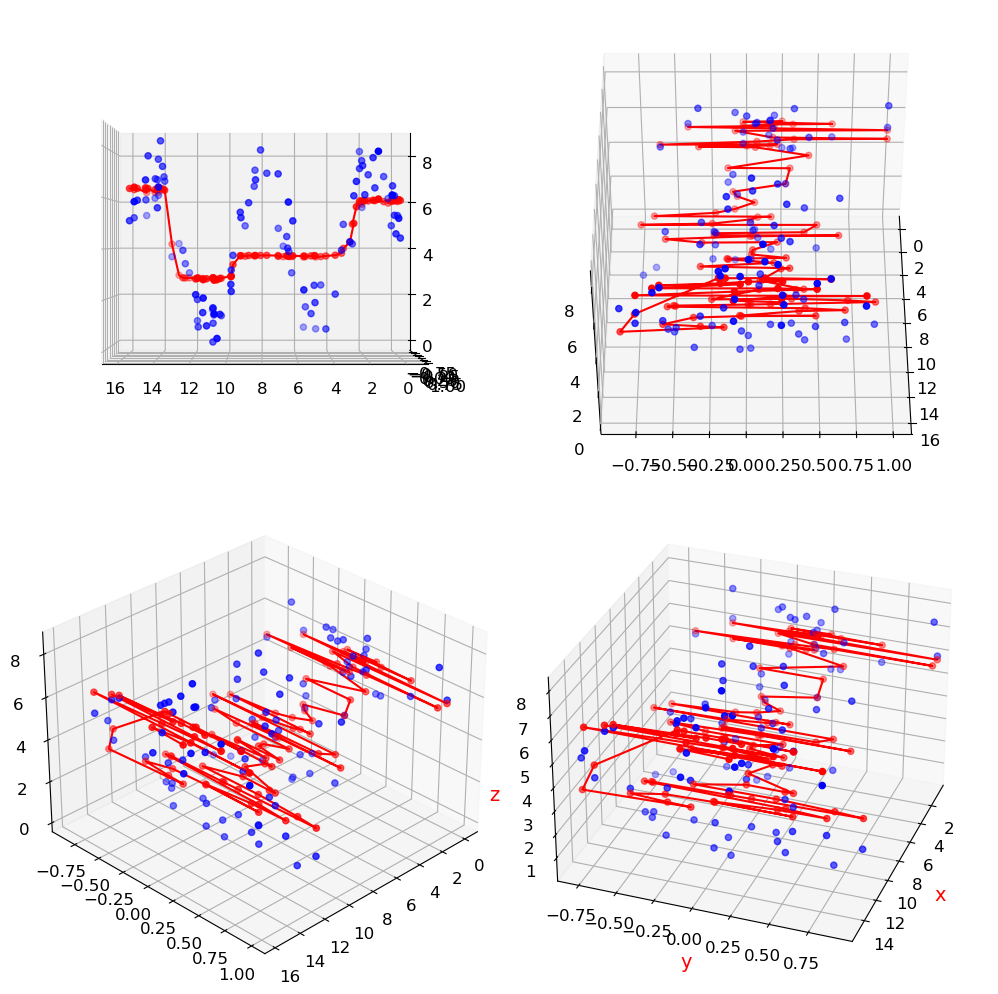

In [86]:
# Plot
plotscatter3Ddata(X_train['x'], X_train['y'], rf_mod_preds,  
                 X_train['x'], X_train['y'], z_train)

### Create Optimal DecisionTreeRegressor Model

In [87]:
# splitter = <'best'>
# max_depth = <7>
# min_samples_split = <10>

# Train model with best parameters
dt_model = DecisionTreeRegressor(splitter='best',
                                 min_samples_split=10,
                                 max_depth=7,
                                 random_state=42)

# Fit model
dt_model.fit(X_train, z_train)

# Use trained model to get predictions
dt_mod_preds = dt_model.predict(X_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

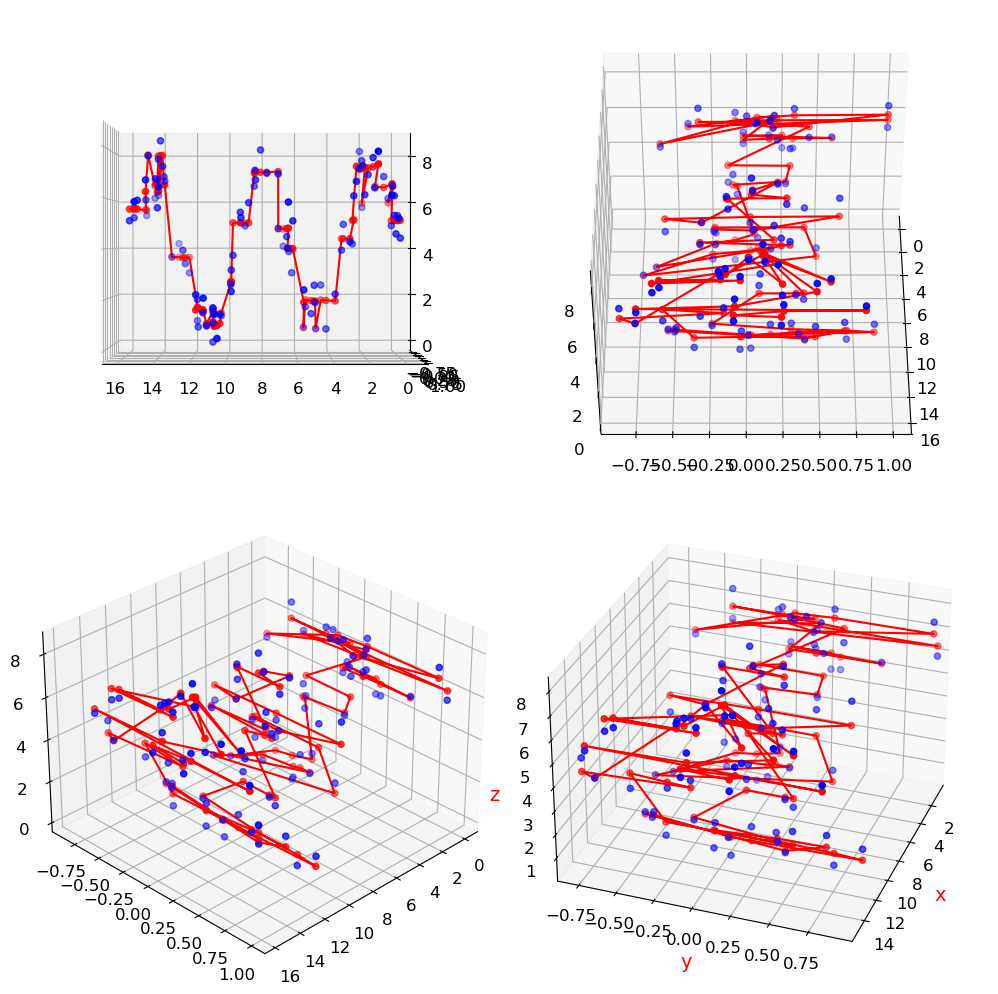

In [88]:
# Plot
plotscatter3Ddata(X_train['x'], X_train['y'], dt_mod_preds, X_train['x'], X_train['y'], z_train)

# Compute Generalization Error

Compute the generalization error for each of the optimal models computed above.  Use MSE as the generalization error metric.  Round your answers to four decimal places.  Print the generalization error for all three models.

In [89]:
# Generate predictions on test set
gb_mod_preds = gb_model.predict(X_test)  
rf_mod_preds = rf_model.predict(X_test)
dt_mod_preds = dt_model.predict(X_test)

# Get errors
gb_errors = z_test - gb_mod_preds
rf_errors = z_test - rf_mod_preds  
dt_errors = z_test - dt_mod_preds

# Calculate all the error statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the mean squared error
gb_mse = mean_squared_error(z_test, gb_mod_preds)
rf_mse = mean_squared_error(z_test, rf_mod_preds)
dt_mse = mean_squared_error(z_test, dt_mod_preds)

# Calculate the mean absolute error
gb_mae = mean_absolute_error(z_test, gb_mod_preds)
rf_mae = mean_absolute_error(z_test, rf_mod_preds)
dt_mae = mean_absolute_error(z_test, dt_mod_preds)

# Calculate the (arithmatic) mean, median, and standard deviation
gb_mean = np.mean(gb_errors)
rf_mean = np.mean(rf_errors)
dt_mean = np.mean(dt_errors)

gb_median = np.median(np.absolute(gb_errors))
rf_median = np.median(np.absolute(rf_errors))
dt_median = np.median(np.absolute(dt_errors))

gb_std = np.std(gb_errors)
rf_std = np.std(rf_errors)
dt_std = np.std(dt_errors)

# IQR values
gb_iqr = np.percentile(gb_errors, 75) - np.percentile(gb_errors, 25)
rf_iqr = np.percentile(rf_errors, 75) - np.percentile(rf_errors, 25)
dt_iqr = np.percentile(dt_errors, 75) - np.percentile(dt_errors, 25)

# Print error statistics for each model
print('Gradient Boosting error stats:')
print(f'MSE: {gb_mse:.4f}')
print(f'MAE: {gb_mae:.4f}')
print(f'Mean: {gb_mean:.4f}')
print(f'Median: {gb_median:.4f}')
print(f'Std Dev: {gb_std:.4f}')
print(f'IQR: {gb_iqr:.4f}')
print()

print('Random Forest error stats:')
print(f'MSE: {rf_mse:.4f}')
print(f'MAE: {rf_mae:.4f}')
print(f'Mean: {rf_mean:.4f}')
print(f'Median: {rf_median:.4f}')
print(f'Std Dev: {rf_std:.4f}')
print(f'IQR: {rf_iqr:.4f}')
print()

print('Decision Tree error stats:')
print(f'MSE: {dt_mse:.4f}')
print(f'MAE: {dt_mae:.4f}')
print(f'Mean: {dt_mean:.4f}')
print(f'Median: {dt_median:.4f}')
print(f'Std Dev: {dt_std:.4f}')
print(f'IQR: {dt_iqr:.4f}')

Gradient Boosting error stats:
MSE: 0.8968
MAE: 0.6118
Mean: -0.1108
Median: 0.3310
Std Dev: 0.9405
IQR: 0.4229

Random Forest error stats:
MSE: 1.9021
MAE: 1.1307
Mean: 0.1320
Median: 1.0463
Std Dev: 1.3728
IQR: 2.1118

Decision Tree error stats:
MSE: 0.7264
MAE: 0.6855
Mean: 0.1214
Median: 0.4945
Std Dev: 0.8436
IQR: 1.3042


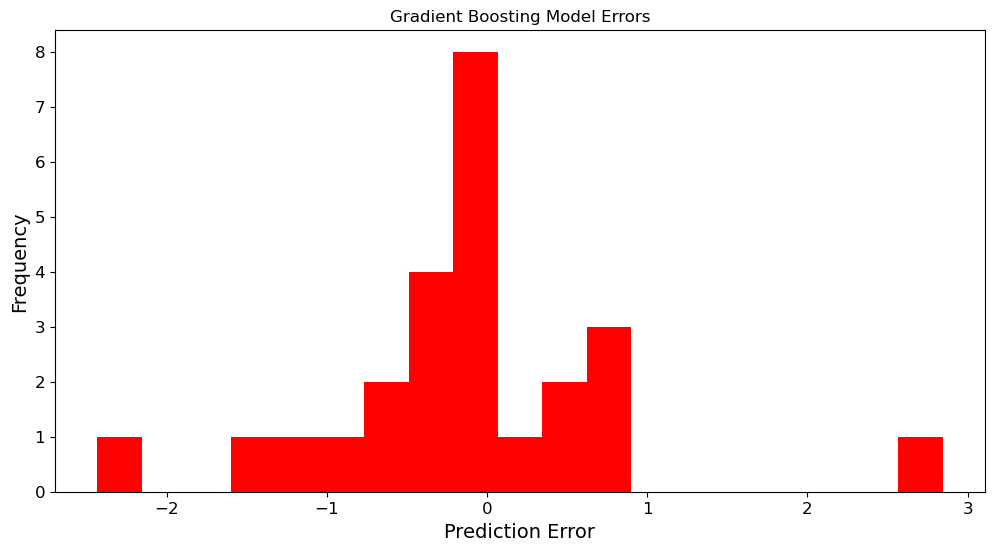

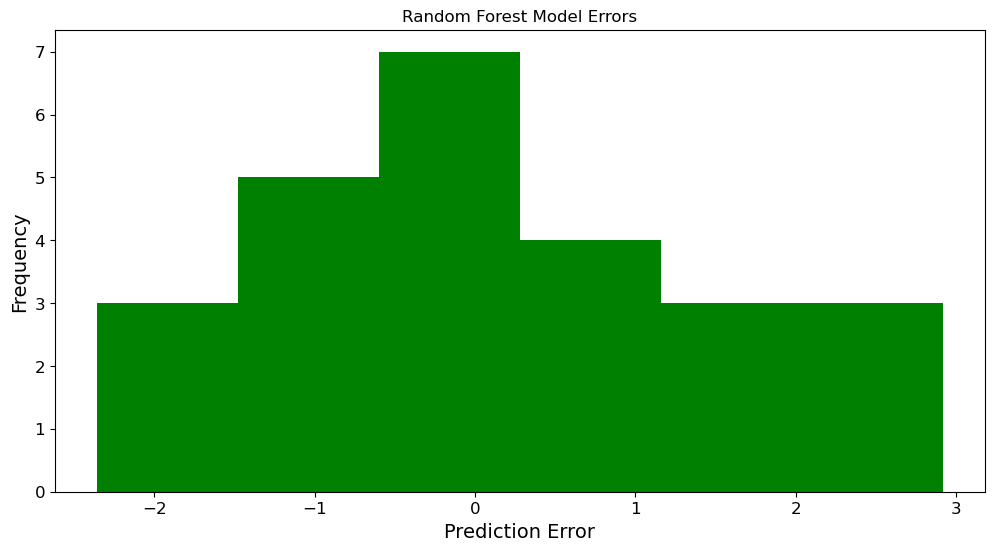

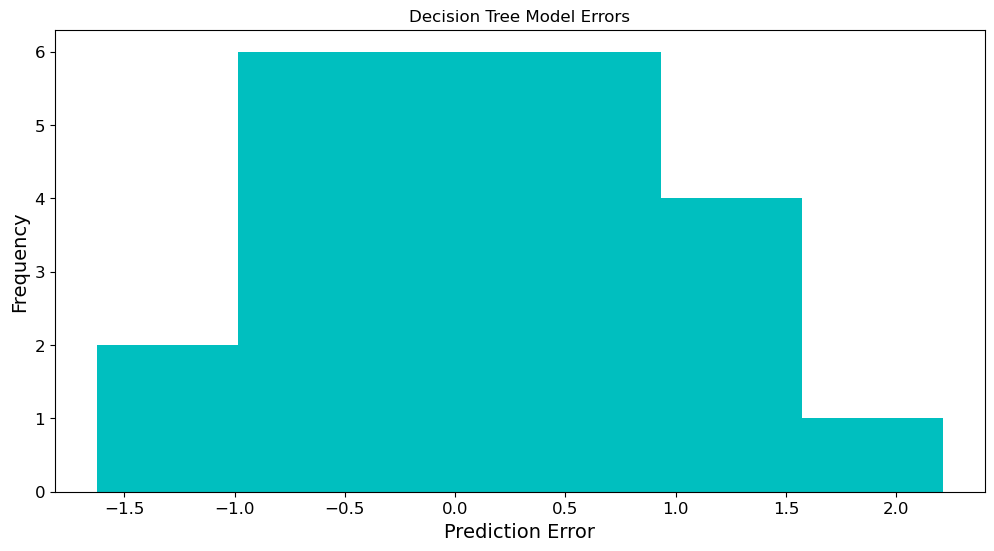

In [90]:
# Plot Histograms for critical analysis

# Plot histogram for Gradient Boosting errors
fig = plt.figure(figsize=(12,6))
gb_error_plot = fig.add_subplot(1, 1, 1)
gb_error_plot.hist(gb_errors, bins='auto', color='r')
gb_error_plot.set_xlabel('Prediction Error')
gb_error_plot.set_ylabel('Frequency')
gb_error_plot.set_title('Gradient Boosting Model Errors')
fig.savefig('gb_model_error_histogram.png')

# Plot histogram for Random Forest errors
fig = plt.figure(figsize=(12,6))
rf_error_plot = fig.add_subplot(1, 1, 1)
rf_error_plot.hist(rf_errors, bins='auto', color='g')
rf_error_plot.set_xlabel('Prediction Error')
rf_error_plot.set_ylabel('Frequency')
rf_error_plot.set_title('Random Forest Model Errors')
fig.savefig('rf_model_error_histogram.png')

# Plot histogram for Decision Tree errors
fig = plt.figure(figsize=(12,6))
dt_error_plot = fig.add_subplot(1, 1, 1)
dt_error_plot.hist(dt_errors, bins='auto', color='c')
dt_error_plot.set_xlabel('Prediction Error')
dt_error_plot.set_ylabel('Frequency')
dt_error_plot.set_title('Decision Tree Model Errors')
fig.savefig('dt_model_error_histogram.png')